In [ ]:
k%%time
%run -i 'nlp_implementation.py' #imports packages and inits alltext
# from pyspark import SparkContext, SparkConf
import spacy
from spacy.tokens import DocBin

# conf = SparkConf().setAppName("pyspark-shell").setMaster('local[*]').set("spark.executor.memory", "10g").set("spark.driver.memory", "10g").set('spark.driver.maxResultSize', "10G")
# sc = SparkContext(conf=conf)
nlp = spacy.load("en_core_web_lg")
with open("cucumber/all_doc.bin", "rb") as w: #loading in all bytestreams of data
    new_docs1 = DocBin(store_user_data=True).from_bytes(w.read())
docs1 = list(new_docs1.get_docs(nlp.vocab))
with open("cucumber/first_doc.bin", "rb") as w: #loading in
    new_docs1 = DocBin(store_user_data=True).from_bytes(w.read())
docs1 += list(new_docs1.get_docs(nlp.vocab))
print(len(docs1))

In [ ]:
%%time
import wikipedia
# from googlesearch import search
import requests
from bs4 import BeautifulSoup, NavigableString
import pandas as pd
import numpy as np

import os
import multiprocessing as mp
import subprocess
import concurrent.futures
from difflib import SequenceMatcher
import csv

books_df = pd.read_csv('books_clean.csv')
def is_book1(name, df=books_df): #worker
#     print("trying", name)
    db, wiki, = False, False  
    if name in df.title.values:
        db = True
    similar = ["book", "volume", "novel", "work", "publication", "title", "treatise"]
    try:
        summ = wikipedia.summary(name, sentences=3)
        if any([x in summ.lower() for x in similar]):
            wiki =True
    except:
        pass

    if db or wiki:
        print(name)
        return(name, True)
#     links = search(name)
#     websites_matched = 0
#     for l in links:
#         if bool(re.search("amazon.*dp", l)):
#             websites_matched+=1
#         if bool(re.search("books\.google.*"+name.replace(" ", "_").lower(), l.lower())):
#             websites_matched+=1
#         if bool(re.search("goodreads*"+name.replace(" ", "_").lower(), l.lower())):
#             websites_matched+=1
#         if bool(re.search("barnesandnoble*"+name.replace(" ", "_").lower(), l.lower())):
#             websites_matched+=1
#         if bool(re.search("penguinrandomhouse*"+name.replace(" ", "_").lower(), l.lower())):
#             websites_matched+=1

#     if websites_matched>2 or sum([bool(re.search("book", l.lower())) for l in links])>4:
#         return (name, True) 
    
    return (name, False)

        
def keep_stuff1(doc):
    books, people, places = [], [], []
    ents = doc.user_data["entis"]
    potential = ["WORK_OF_ART"]
    
    for ent, label in ents:
        if label=="PERSON": #save people entities
            people.append(ent)
        elif label=="LOC" or label=="GPE": #save location entites
            places.append(ent)
    #parallel processing to verify books
    with concurrent.futures.ThreadPoolExecutor(max_workers = 20) as executor:
        result = [executor.submit(is_book1, e[0]) for e in ents if e[1] in potential]
    for future in concurrent.futures.as_completed(result):
        print(future.result())
        if future.result()[1]==True:
            books.append(future.result()[0])
    doc.user_data["places"] = places
    doc.user_data["people"] = people
    doc.user_data["books"] = books
#     doc.user_data["people"] = [person[0] for person in ents if person[1]=="PERSON"]
#     doc.user_data["place"] = [place[0] for place in ents if place[1]=="LOC" or place[1]=="GPE"]
#     doc.user_data["book"] = [book[0] for book in ents if book[1] in potential]
    
    
    return doc
docs1 = [keep_stuff1(doc) for doc in docs1] #extract and save all entities by running above method

In [ ]:
from collections import Counter
def att_to_csv(docs, atts):
    all_atts= sorted(set([item for sublist in docs for item in sublist.user_data[atts]])) #all books
    all_attributes=dict([(x, [x]) for x in all_atts]) #dictionary of books to become key is base book, value are similar titles
    i = 0
#     print(len(all_attributes))
#     similar_words implement dictionary to store similar words that were deleted
    while i<len(all_attributes)-1: #remove similar or subwords
        str1, str2 = all_atts[i], all_atts[i+1]
        if str2 in str1 or (SequenceMatcher(a=str1,b=str2).ratio()>.8 and len(str1)>len(str2)):
            toRemove = all_attributes.get(str2) #list of similar words moving
            toKeep =  all_attributes.get(str1)
            del all_attributes[str2]
            all_attributes[str1] = toRemove+toKeep
        elif str1 in str2 or (SequenceMatcher(a=str1,b=str2).ratio()>.8 and len(str1)<=len(str2)):
            toRemove = all_attributes.get(str1) #list of similar words moving
            toKeep =  all_attributes.get(str2)
            del all_attributes[str1]
            all_attributes[str2] = toRemove+toKeep
            
        i+=1
    print((all_attributes))    
    new_dic = {} #reverse dict so that given any name, can find base
    for k,v in all_attributes.items():
        for x in v:
            new_dic.setdefault(x,[]).append(k)
    #now have dict of base books with values of similar titles
        
    all_attributes_dict = dict(zip(all_attributes.keys(), np.arange(len(all_attributes)))) #create dict for all entities
    
    
    guests = [doc.user_data["guest"] for doc in docs]
    guests_dict = dict(zip(guests, np.arange(len(all_attributes), len(all_attributes)+len(guests))))#create dict for all main
    
#     #now create dict for all edges by going from every doc's mentions of attribute, and adding edge from guest to attribute
    
    i = len(guests) + len(all_attributes) #make keys for final edges

#     print(all_attributes_dict.get((new_dic.get('A Course in Miracles')[0])))
    edges = []
    for doc in docs:
        current_name = guests_dict.get(doc.user_data["guest"]) #get graph id for each guest in doc
        for mention in doc.user_data[atts]:
            if new_dic.get(mention):
#                 print(new_dic.get(mention))
                edges.append((current_name, all_attributes_dict.get(new_dic.get(mention)[0]))) #from speaker to mention of base book
#     print(edges)
    edges_dict=dict(zip(edges, np.arange(i, i+len(edges))))
    
    
    
    with open(atts+"Nodes.csv", "w+") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["id", "name", "group"])
        for ind, key in enumerate(all_attributes.keys()): #key is attriubte name, value is id
            writer.writerow([ind, key, 2])
        for key, value in guests_dict.items():
            writer.writerow([value, key, 1]) # group 2 is entities, group 1 is speakers
    with open(atts+"Edges.csv", "w+") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["id", "source", "target", "value"])
        for key, value in edges_dict.items():
            writer.writerow([value, key[0], key[1], 1])
att_to_csv(docs1, "books")

In [ ]:
# att_to_csv(docs1, "places")
# att_to_csv(docs1, "books")
from collections import Counter

all_attributes= Counter([item for sublist in docs1 for item in sublist.user_data["books"]])
for item in all_attributes.items():
    print(item)

In [7]:
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

edges = pd.read_csv("booksEdges.csv", sep=',')
edges.drop("id", axis=1)
G = nx.from_pandas_edgelist(edges, 'source','target', ['value'])

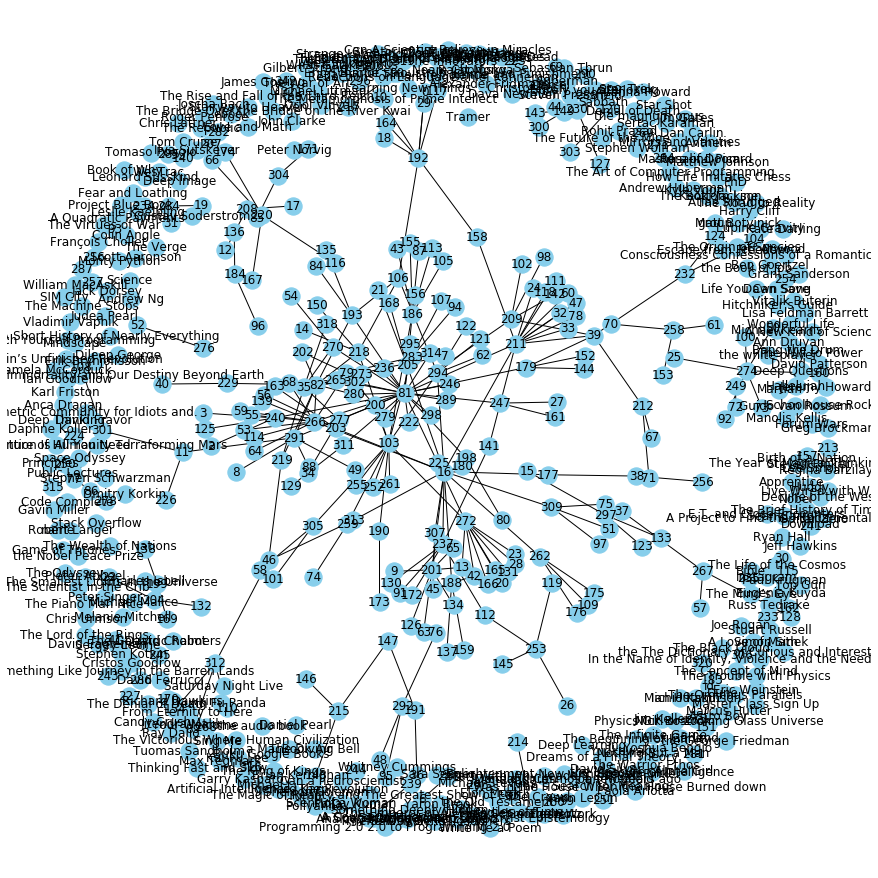

In [23]:



nodes = pd.read_csv('booksNodes.csv',sep=',')
data = nodes.set_index("id").to_dict("index").items()
G.add_nodes_from(data)


plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=.15)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [44]:
nodes = pd.read_csv('booksNodes.csv',sep=',').set_index("id").to_dict("index")
print(nodes.get(177))

{'name': 'Matthew Johnson', 'group': 1}


In [33]:
edges = pd.read_csv("booksEdges.csv", sep=',').drop("id", axis=1).values.tolist()
print(edges[0])

[177, 38, 1]


In [43]:
# # extract subject
# source = [i[0] for i in entity_pairs]

# # extract object
# target = [i[1] for i in entity_pairs]

# kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
# print(type(kg_df))
# # create a directed-graph from a dataframe
# G=nx.from_pandas_edgelist(kg_df, "source", "target", 
#                           edge_attr=True, create_using=nx.MultiDiGraph())
# plt.figure(figsize=(12,12))

# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

NameError: name 'entity_pairs' is not defined

<class 'pandas.core.frame.DataFrame'>


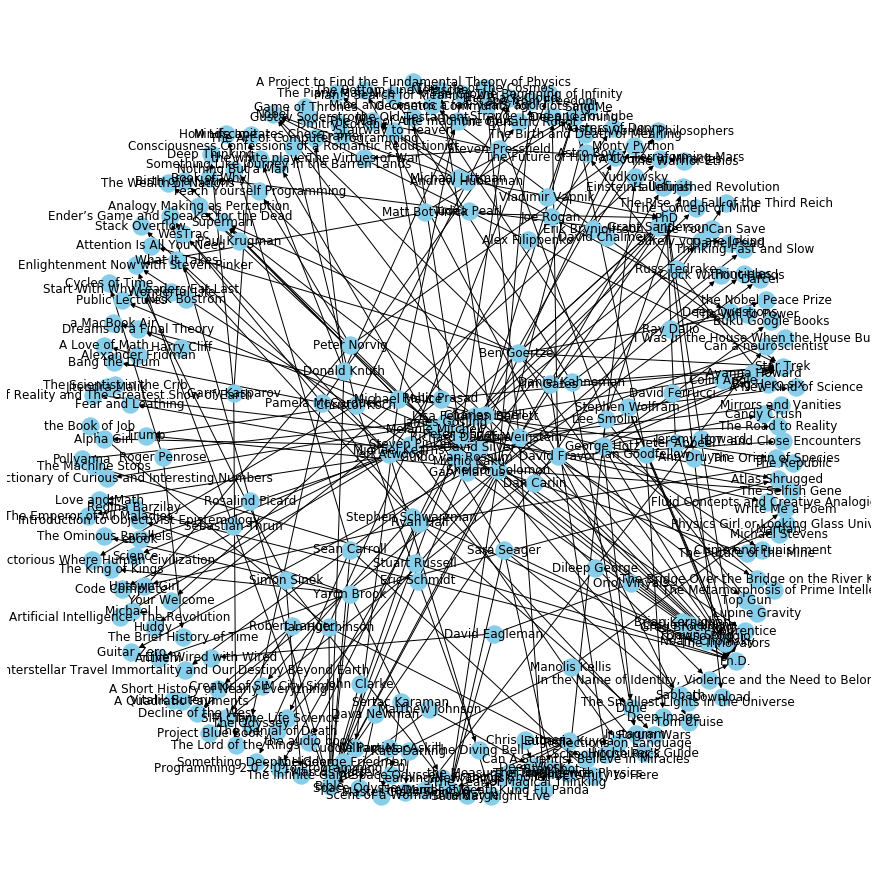

In [60]:
import numpy as np
source = [nodes.get(e[0])["name"] for e in edges]
target = [nodes.get(e[1])["name"] for e in edges]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':np.ones(len(source))})
print(type(kg_df))
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


In [57]:
print(list(nodes.values())[0])

{'name': 'A Course in Miracles', 'group': 2}


In [46]:
print(source[0])

Matthew Johnson


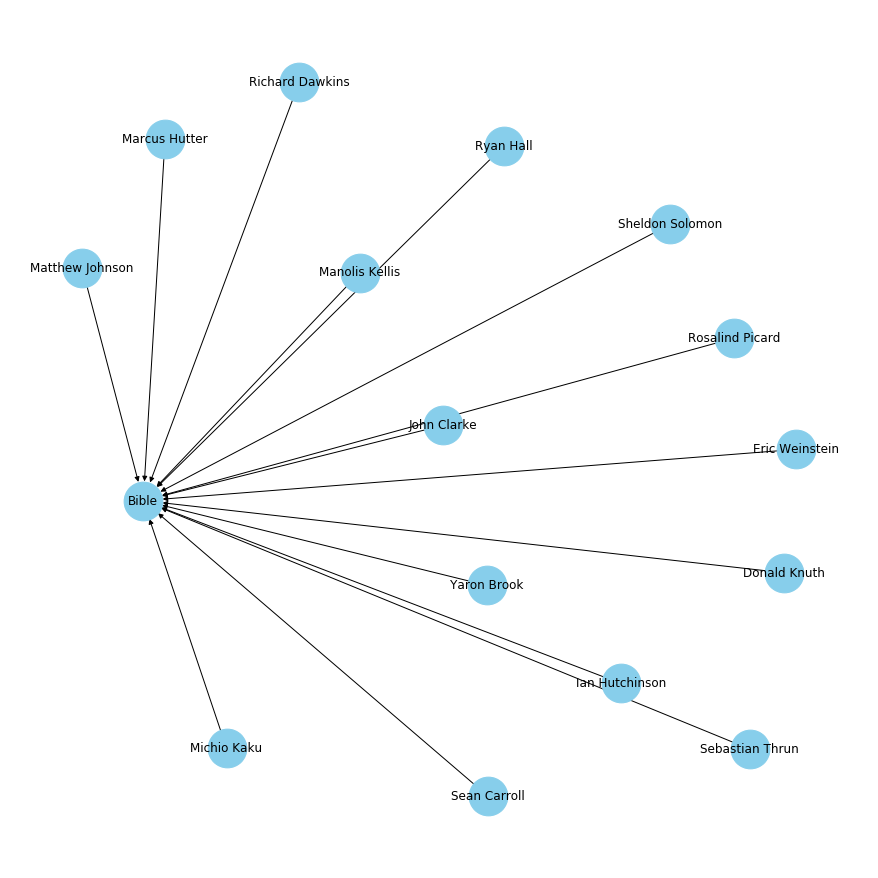

In [61]:
G=nx.from_pandas_edgelist(kg_df[kg_df['target']=="Bible"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes



nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()